In [1]:
import pandas as pd
import re
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import unicodedata
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## 데이터 불러오기

In [2]:
file_path = 'C:/users/juwon/practice_aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names = ['eng', 'fra','cc'], sep='\t')
lines.head()

,eng,fra,cc
0,Go.,Va !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1,Go.,Marche.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
2,Go.,En route !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
3,Go.,Bouge !,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
4,Hi.,Salut !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [3]:
lines = lines[['eng', 'fra']][:33000]
lines.sample(5)

,eng,fra
3463,I'm relaxed.,Je suis détendue.
10287,I am in a spot.,Je suis dans un endroit.
8328,People change.,Les gens changent.
17395,Are you a golfer?,Es-tu golfeur ?
27357,We've got to talk.,Nous devons parler.


## 문장 전처리

In [4]:
def to_ascii(sentence):
    return ''.join(c for c in unicodedata.normalize('NFD', sentence) if unicodedata.category(c) != 'Mn')

# https://wikidocs.net/86900 참고

In [34]:
to_ascii(lines.fra[551])

'allez y !'

In [6]:
def preprocessing_sentence(sentence):
    to_ascii(sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'([?.!,¿-])', r" \1 ", sentence)
    sentence = re.sub(r'[" "]+' , " ", sentence)
    sentence = re.sub(r'[^a-zA-Z?.!,¿]+', r" ", sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
lines.eng = lines.eng.apply(preprocessing_sentence)
lines.fra = lines.fra.apply(preprocessing_sentence)

In [8]:
input_text = [a.split() for a in lines.eng]

encoder_input = input_text
input_text[:3]

[['go', '.'], ['go', '.'], ['go', '.']]

In [9]:
output_text = [('<sos> '+a+' <eos>').split() for a in lines.fra]
decoder_input = [a[:-1] for a in output_text]
decoder_target = [a[1:] for a in output_text]
print(output_text[:3])
print(decoder_input[:3])
print(decoder_target[:3])

[['<sos>', 'va', '!', '<eos>'], ['<sos>', 'marche', '.', '<eos>'], ['<sos>', 'en', 'route', '!', '<eos>']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>']]


In [125]:
print(input_text[551])
print(output_text[551])

['go', 'ahead', '!']
['<sos>', 'allez', 'y', '!', '<eos>']


In [11]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(encoder_input)
encoder_input = eng_tokenizer.texts_to_sequences(encoder_input)
encoder_input[:5]

[[28, 1], [28, 1], [28, 1], [28, 1], [762, 1]]

## 문장 토큰화 및 패딩

In [12]:
fra_tokenizer = Tokenizer(lower=False)
fra_tokenizer.fit_on_texts(output_text)
decoder_input = fra_tokenizer.texts_to_sequences(decoder_input)
decoder_input[:5]

[[1, 76, 8], [1, 366, 3], [1, 28, 513, 8], [1, 717, 8], [1, 751, 8]]

In [13]:
fra_tokenizer = Tokenizer(lower=False)
fra_tokenizer.fit_on_texts(output_text)
decoder_target = fra_tokenizer.texts_to_sequences(decoder_target)
decoder_target[:5]

[[76, 8, 2], [366, 3, 2], [28, 513, 8, 2], [717, 8, 2], [751, 8, 2]]

In [14]:
eng_voc_size = len(eng_tokenizer.word_index) + 1
fra_voc_size = len(fra_tokenizer.word_index) + 1

In [15]:
print('영어 단어장 크기:',eng_voc_size)
print('프랑스어 단어장 크기:',fra_voc_size)

영어 단어장 크기: 4672
프랑스어 단어장 크기: 7455


In [10]:
maxlen_eng = max([len(a) for a in encoder_input])
maxlen_fra = max([len(a) for a in decoder_input])
print(maxlen_eng)
print(maxlen_fra) # 시작, 종료토큰포함

8
16


In [16]:
encoder_input = pad_sequences(encoder_input, padding='post', maxlen = maxlen_eng)
decoder_input = pad_sequences(decoder_input, padding='post', maxlen = maxlen_fra)
decoder_target = pad_sequences(decoder_target, padding ='post', maxlen = maxlen_fra)

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 16)
프랑스어 출력데이터의 크기(shape) : (33000, 16)


## 학습, 평가 데이터 분할

In [17]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 훈련 데이터 크기: ',encoder_input_train.shape)
print('프랑스 훈련 데이터 크기: ',decoder_input_train.shape)
print('프랑스 테스트 라벨 데이터 크기: ',decoder_target_test.shape)

영어 훈련 데이터 크기:  (30000, 8)
프랑스 훈련 데이터 크기:  (30000, 16)
프랑스 테스트 라벨 데이터 크기:  (3000, 16)


In [18]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

## 인코더 설계

In [104]:
embbeding_dim = 64
hidden_units = 128

In [105]:
encoder_inputs = Input(shape=(None,))
encoder_embbeding = Embedding(eng_voc_size, embbeding_dim)(encoder_inputs)
encoder_masking = Masking(mask_value = 0.0)(encoder_embbeding) 
encoder_lstm = LSTM(hidden_units, return_state = True)
encoder_outputs, state_h, state_c =encoder_lstm(encoder_masking)
encoder_states = [state_h, state_c]

## 디코더 입력 설계

In [106]:
decoder_inputs = Input(shape=(None,))
decoder_embbeding = Embedding(fra_voc_size, embbeding_dim)(decoder_inputs)
decoder_masking = Masking(mask_value=0.0)(decoder_embbeding)
decoder_lstm = LSTM(hidden_units, return_sequences = True, return_state = True)
decoder_outputs, _, _ = decoder_lstm(decoder_masking, initial_state = encoder_states)

## 디코더 출력

In [107]:
decoder_softmax_layer = Dense(fra_voc_size, activation ='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [108]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer ='rmsprop',
             loss ='sparse_categorical_crossentropy')
model.summary()

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, None, 64)     299008      ['input_21[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, None, 64)     477120      ['input_22[0][0]']               
                                                                                           

In [109]:
epochs = 23
batch_size = 128 
history = model.fit(x=[encoder_input_train, decoder_input_train], y = decoder_target_train,
         validation_data =([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=batch_size, epochs = epochs)

Epoch 1/23
235/235 [==============================] - 25s 49ms/step - loss: 2.2563 - val_loss: 1.9682
Epoch 2/23
235/235 [==============================] - 7s 32ms/step - loss: 1.5714 - val_loss: 1.8154
Epoch 3/23
235/235 [==============================] - 7s 31ms/step - loss: 1.4108 - val_loss: 1.7094
Epoch 4/23
235/235 [==============================] - 7s 30ms/step - loss: 1.2900 - val_loss: 1.6161
Epoch 5/23
235/235 [==============================] - 7s 31ms/step - loss: 1.2045 - val_loss: 1.5244
Epoch 6/23
235/235 [==============================] - 7s 31ms/step - loss: 1.1396 - val_loss: 1.4787
Epoch 7/23
235/235 [==============================] - 7s 30ms/step - loss: 1.0859 - val_loss: 1.4208
Epoch 8/23
235/235 [==============================] - 7s 30ms/step - loss: 1.0378 - val_loss: 1.4031
Epoch 9/23
235/235 [==============================] - 7s 30ms/step - loss: 0.9969 - val_loss: 1.3733
Epoch 10/23
235/235 [==============================] - 7s 32ms/step - loss: 0.9594 - val_l

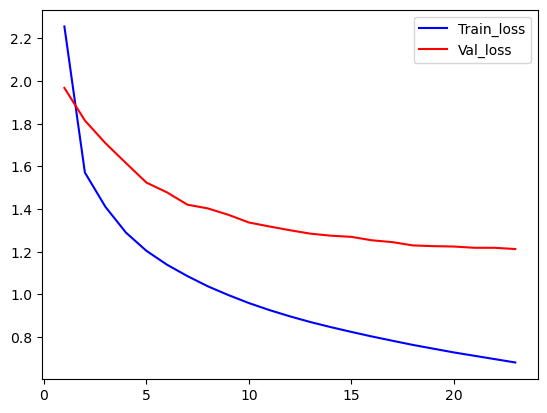

In [110]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,epochs)
plt.plot(epochs, train_loss,'b',label = 'Train_loss')
plt.plot(epochs, val_loss,'r',label = 'Val_loss')
plt.legend()
plt.show()

## 모델 테스트하기

In [111]:
encoder_model = Model(inputs= encoder_inputs, outputs= encoder_states)
encoder_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_10 (Embedding)    (None, None, 64)          299008    
                                                                 
 masking_10 (Masking)        (None, None, 64)          0         
                                                                 
 lstm_10 (LSTM)              [(None, 128),             98816     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 397,824
Trainable params: 397,824
Non-trainable params: 0
_________________________________________________________________


In [112]:
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_embbeding, initial_state= decoder_states_inputs)
decoder_states = [state_h, state_c]

In [113]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs = [decoder_inputs]+ decoder_states_inputs, outputs=[decoder_outputs]+decoder_states)
decoder_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_11 (Embedding)       (None, None, 64)     477120      ['input_22[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 128)]        0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 128)]        0           []                               
                                                                                           

In [114]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [115]:
def decode_sequence(input_seq): 
    state_values = encoder_model.predict(input_seq,verbose=0)
    target_seq = np.zeros((1,1))
    target_seq[0,0] = fra2idx['<sos>']
    
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + state_values,verbose=0)
        
        sampled_token_index = np.argmax(output_tokens[0,-1,:])
        sampled_seq = idx2fra[sampled_token_index]
        
        decoded_sentence += sampled_seq+ ' '
        
        if (sampled_seq=='<eos>' or len(decoded_sentence.split()) > maxlen_fra) : 
            stop_condition = True
            
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        state_values= [h,c]
    return decoded_sentence

## 비교해보기
### 입력된 문장 출력

In [116]:
def seq2input(input_seq):
    sentence = ''
    for token in input_seq :
        if (token != 0) :
            sentence += idx2eng[token]+ ' '
    return sentence

### 정답 문장 출력

In [117]:
def seq2target(input_seq):
    sentence =''
    for token in input_seq :
        if (token !=0 and token != fra2idx['<sos>'] and token != fra2idx['<eos>']) :
            sentence += idx2fra[token] + ' '
    return sentence

In [126]:
seq_index = [2,111,201,551,1000]
for index in seq_index:
    input_seq= encoder_input_train[index:index+1]
    decoded_sequence = decode_sequence(input_seq)
    print('입력된 문장: ', seq2input(encoder_input_train[index]))
    print('정답 문장 : ',seq2target(decoder_input_train[index]))
    print('번역한 문장: ', decoded_sequence[:-6])
    print('-' *50)

입력된 문장:  go . 
정답 문장 :  en route ! 
번역한 문장:  va y ! 
--------------------------------------------------
입력된 문장:  i left . 
정답 문장 :  je suis partie . 
번역한 문장:  j ai eu de l eau . 
--------------------------------------------------
입력된 문장:  bury it . 
정답 문장 :  enterrez la . 
번역한 문장:  ceci . 
--------------------------------------------------
입력된 문장:  go ahead ! 
정답 문장 :  allez y ! 
번역한 문장:  allez ! 
--------------------------------------------------
입력된 문장:  here i am . 
정답 문장 :  me voici . 
번역한 문장:  je suis en s ! 
--------------------------------------------------


In [127]:
for index in seq_index:
    input_seq= encoder_input_test[index:index+1]
    decoded_sequence = decode_sequence(input_seq)
    print('입력된 문장: ', seq2input(encoder_input_test[index]))
    print('정답 문장 : ',seq2target(decoder_input_test[index]))
    print('번역한 문장: ', decoded_sequence[:-6])
    print('-' *50)

입력된 문장:  i love korean food . 
정답 문장 :  j adore la cuisine cor enne . 
번역한 문장:  j aime le chien . 
--------------------------------------------------
입력된 문장:  i often wear a hat . 
정답 문장 :  je porte souvent un chapeau . 
번역한 문장:  je mange des enfants . 
--------------------------------------------------
입력된 문장:  i smoke cigarettes . 
정답 문장 :  je fume des cigarettes . 
번역한 문장:  je vais la maison . 
--------------------------------------------------
입력된 문장:  i m as tall as you . 
정답 문장 :  je suis aussi grande que vous . 
번역한 문장:  je suis si grand gar on . 
--------------------------------------------------
입력된 문장:  it wasn t very fun . 
정답 문장 :  ce ne fut pas tr s amusant . 
번역한 문장:  ce n tait pas un gar on . 
--------------------------------------------------


## 한국어로 번역 비교
프랑스어를 영어로 바꿔주는 구글 번역기를 참고하여 적었습니다.

### 1.Train
입력된 문장:  go . 가자!   
정답 문장 :  en route !   
번역한 문장:  va y !   >> 영어로 번역한 문장 :go!, 가자! 번역 성공
--------------------------------------------------
입력된 문장:  i left . 나는 떠났다.   
정답 문장 :  je suis partie .   
번역한 문장:  j ai eu de l eau .   >> I had water,  '나는 물을 가졌다', 주어와 과거형은 맞추었다.
--------------------------------------------------
입력된 문장:  bury it . 묻어.   
정답 문장 :  enterrez la .   
번역한 문장:  ceci .   >> this, '이것', 동사를 번역하지 못했다.
--------------------------------------------------
입력된 문장:  go ahead ! 어서해!     
정답 문장 :  allez y !    
번역한 문장:  allez !   >> go ahead, '어서 해' , come on도 나오지만 비슷하므로 번역에 성공
--------------------------------------------------
입력된 문장:  here i am . 나 여기야   
정답 문장 :  me voici .   
번역한 문장:  je suis en s !   >> I am in s !, '나는 s에 있어' s라는 단어는 악센트가 생략된 것 같다. 하지만 입력된 문장은 나의 위치를 알리는 말이므로 성공했다고 볼 수 있다.
--------------------------------------------------

## 2. Test

입력된 문장:  i love korean food . '나는 한국음식을 사랑한다.'    
정답 문장 :  j adore la cuisine cor enne .    
번역한 문장:  j aime le chien . '나는 개를 사랑한다.' 한국음식을 개로 번역했다.   
--------------------------------------------------
입력된 문장:  i often wear a hat . '나는 가끔 모자를 쓴다.'   
정답 문장 :  je porte souvent un chapeau .    
번역한 문장:  je mange des enfants .  '나는 아이들을 먹는다.'     
--------------------------------------------------
입력된 문장:  i smoke cigarettes . '나는 담배를 핀다.'   
정답 문장 :  je fume des cigarettes .    
번역한 문장:  je vais la maison . '나는 집에 가는중이다'   
--------------------------------------------------
입력된 문장:  i m as tall as you . '나는 너만큼 크다'   
정답 문장 :  je suis aussi grande que vous .    
번역한 문장:  je suis si grand gar on . '나는 꽤 큰 남자다.'   
--------------------------------------------------
입력된 문장:  it wasn t very fun . '그건 재미 있지 않았어.'   
정답 문장 :  ce ne fut pas tr s amusant .    
번역한 문장:  ce n tait pas un gar on . '그건 소년이 아니었어.'   
--------------------------------------------------

### 회고
seq2seq의 모델구조를 이해하지 못하여 매우 힘든 과정이었다.   
하지만 과정에 비해 결과가 만족스럽지 못했다.   
Train같은 경우는 완벽히 맞춘 문장이 있었고, 못맞춘 문장은 문맥상 맞거나 동사 부분을 번역하지 못했다.   
Test의 경우 완벽히 맞춘문장은 없었고 4번 문장이 문맥상 비슷했고, 나머지는 다른 의미로 번역을 했다.   
Train은 이미 학습했던 문장을 한번 더 번역해보았기 때문에 정확도가 높았고, test는 학습하지 않았던 문장을 넣어줬기 때문에
위와 같은 결과가 나왔다고 생각한다.     
test문장의 정확도 향상을 위해서 임베딩 차원수와 lstm유닛수를 조절해봐야 할 것 같다.